### This notebook enables to detect those cases in which there is no Site coordinates reported, but the Dec/Inc and Plat/Plon coordinates allow its calculation

In [1]:
import os
import numpy as np
import pandas as pd
from pmagpy import ipmag, pmag
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
from scipy import optimize
import seaborn as sns

from scripts.auxiliar import get_files_in_directory, spherical2cartesian, cartesian2spherical, GCD_cartesian
pd.set_option('display.max_columns', None)

### Displaying all the csv file in the vgp_database folder

In [131]:
current_path = os.getcwd()
data_path_VGP = current_path + '/vgp_database'
files_names = get_files_in_directory(data_path_VGP)

csv_file_names = [os.path.splitext(os.path.basename(open(file,'r').name))[0] for file in files_names if file.endswith('.csv')] #consider just *csv files
xlsx_file_names = [os.path.splitext(os.path.basename(open(file,'r').name))[0] for file in files_names if file.endswith('.xlsx')] #consider just *csv files
paths = [file for file in files_names if file.endswith('.xlsx')] 
df_files = pd.DataFrame({'path': paths,  'name_xlsx': xlsx_file_names})
df_files[['name_xlsx']]

,name_xlsx
0,Tequila_volcanic_field
1,Coso_Range_volcanics
2,Eastern_Alkaline_Province
3,SW_USA_composite
4,Stanislaus_Group
5,N_Montana_intrusions
6,Long_Valley_Caldera_volcanics
7,Robinson_Antincline_intrusions
8,Central_Mexico_Plio-Pleistocene
9,Rattlesnake_Hills_volcanics


### Select by index the file you want to display

In [225]:
index = 32

#### Separate the *.csv file into two different DFs, `df_vgps` and `df_poles`. Note: the csv has to be separated by just one blank row
- On the one hand, we have the poles tagged by different criterias.
- On the other hand, we have a DF for every single direction/vgp/site resported by the original paper

In [226]:
df = pd.read_excel(df_files['path'][index]) #, skip_blank_lines=True

In [227]:
df_poles = pd.read_excel(df_files['path'][index], 
                         skiprows = df[df.iloc[:,0]=='Study level data'].index[0]+2,
                         nrows  = df[df.isnull().all(1)].index[1] -3)

df_vgps = pd.read_excel(df_files['path'][index], 
                        skiprows = df[df.iloc[:,0]=='Site level data'].index[0]+2)

#cast columns
df_vgps = df_vgps.astype({'in_study_pole': int,
                          "slat":float, "slon":float, "dec":float, "inc":float,
                          "VGP_lat":float, "VGP_lon":float
                         })
df_poles = df_poles.astype({'N': int,
                          "slat":float, "slon":float, "dec":float, "inc":float,
                          "Plat":float, "Plon":float})

In [228]:
df_vgps.head()

,name,fm./loc.,slat,slon,n,dec,inc,k,alpha95,f_corr,VGP_lat,VGP_lon,K,A95,dp,dm,mean_age,min_age,2sig_min,max_age,2sig_max,uncer_dist,rock_typ_1,rock_typ_2,rock_typ_3,demag,struc_cont,rot_area,polarity,strat_group,ordering,synch_unit,in_study_pole,rej_crit,pmag_ref,age_ref,pmag_comments,age_comments
0,1,"Eocene dikes around Monterey, Virginia",NaN,NaN,5,356.1,56.3,125.9,6.8,NaN,86.6,167.7,NaN,NaN,NaN,NaN,NaN,47,0.2,47.9,0.2,uniform,igneous,shallow intrusive,felsite dike,NaN,NaN,NaN,N,0,NaN,0,1,NaN,Løvlie and Opdyke (1974),Mazza et al. (2014); but additional age data i...,NaN,Using range of Ar-Ar ages reported by Mazza et...
1,2,"Eocene dikes around Monterey, Virginia",NaN,NaN,2,188.4,-48.1,539.9,10.8,NaN,78.6,240.8,NaN,NaN,NaN,NaN,NaN,47,0.2,47.9,0.2,uniform,igneous,shallow intrusive,felsite dike,NaN,NaN,NaN,R,0,NaN,0,1,NaN,Løvlie and Opdyke (1974),Mazza et al. (2014); but additional age data i...,NaN,Using range of Ar-Ar ages reported by Mazza et...
2,3,"Eocene dikes around Monterey, Virginia",NaN,NaN,7,176.8,-50.2,78.4,6.9,NaN,82.3,301.7,NaN,NaN,NaN,NaN,NaN,47,0.2,47.9,0.2,uniform,igneous,shallow intrusive,felsite dike,NaN,NaN,NaN,R,0,NaN,0,1,NaN,Løvlie and Opdyke (1974),Mazza et al. (2014); but additional age data i...,NaN,Using range of Ar-Ar ages reported by Mazza et...
3,6,"Eocene dikes around Monterey, Virginia",NaN,NaN,11,349.4,67.7,16.0,11.8,NaN,75.5,253.0,NaN,NaN,NaN,NaN,NaN,47,0.2,47.9,0.2,uniform,igneous,shallow intrusive,felsite dike,NaN,NaN,NaN,N,0,NaN,0,1,NaN,Løvlie and Opdyke (1974),Mazza et al. (2014); but additional age data i...,NaN,Using range of Ar-Ar ages reported by Mazza et...
4,7,"Eocene dikes around Monterey, Virginia",NaN,NaN,6,208.3,-49.3,33.0,11.8,NaN,65.3,201.2,NaN,NaN,NaN,NaN,NaN,47,0.2,47.9,0.2,uniform,igneous,shallow intrusive,basalt dike,NaN,NaN,NaN,R,0,NaN,0,1,NaN,Løvlie and Opdyke (1974),Mazza et al. (2014); but additional age data i...,NaN,Using range of Ar-Ar ages reported by Mazza et...


## We proceed to populate the VGP DataFrame (`df_vgps`) following different criteria
 - If the site coordinates are reported, we keep them
 - If the site coordinates are not reported, but we have VGP_lat/VGP_lon and dec/inc, we calculate them
 - Otherwise, we keep NaN

In [229]:
# Do the following for the entries with missing slat and slong
df_vgps['Calculate_site'] = df_vgps.apply(lambda row: True if (np.isnan(row.slat) & (~np.isnan(row.VGP_lat) | ~np.isnan(row.dec))) else True, axis =1)

In [230]:
def get_site_coordinates(D, I, Plat, Plon):
    '''
    The following function retrives Site coordinates from Dec/Inc and Plat/Plom
    NOTE! there are always two possible solutions so the outcome is a list in the form [[Slat1, Slon1],[Slat2, Slon2]]
    '''
    paleolat = np.degrees(np.arctan(0.5 * np.tan(np.radians(I))))
    colatitude = 90 - paleolat
    beta = np.degrees(np.arcsin((np.sin(np.radians(colatitude)) * np.sin(np.radians(D))) / (np.cos(np.radians(Plat)))))
    
    def guess(Slat):
        guess = np.arcsin(np.sin(np.radians(Slat)) * np.cos(np.radians(colatitude)) +
                     np.cos(np.radians(Slat)) * np.sin(np.radians(colatitude)) * np.cos(np.radians(D))) - np.radians(Plat)
        return np.degrees(guess)

    sol = optimize.root(guess, x0 = [-90,90],  method='hybr')
    
    res = []
    
    for i in sol.x:
                
        if np.cos(np.radians(colatitude)) > np.sin(np.radians(i)) * np.sin(np.radians(Plat)):            
            Slon = (Plon - beta) % 360.
        else:
            Slon = (Plon - 180 + beta) % 360.
        
        res.append([i,Slon])
    
    return res 

In [231]:
df_vgps['slat_1'] = df_vgps.apply(lambda row: get_site_coordinates(row.dec, row.inc, row.VGP_lat, row.VGP_lon)[0][0] if (row.Calculate_site == True) else row.slat, axis =1) # where 9999 is a function to be built
df_vgps['slon_1'] = df_vgps.apply(lambda row: get_site_coordinates(row.dec, row.inc, row.VGP_lat, row.VGP_lon)[0][1] if (row.Calculate_site == True) else row.slon, axis =1) # where 9999 is a function to be built
df_vgps['slat_2'] = df_vgps.apply(lambda row: get_site_coordinates(row.dec, row.inc, row.VGP_lat, row.VGP_lon)[1][0] if (row.Calculate_site == True) else row.slat, axis =1) # where 9999 is a function to be built
df_vgps['slon_2'] = df_vgps.apply(lambda row: get_site_coordinates(row.dec, row.inc, row.VGP_lat, row.VGP_lon)[1][1] if (row.Calculate_site == True) else row.slon, axis =1) # where 9999 is a function to be built

df_vgps['slat_1'] = df_vgps.apply(lambda row: cartesian2spherical(spherical2cartesian([np.radians(row.slat_1),np.radians(row.slon_1)]))[0]*180/np.pi, axis =1)
df_vgps['slon_1'] = df_vgps.apply(lambda row: cartesian2spherical(spherical2cartesian([np.radians(row.slat_1),np.radians(row.slon_1)]))[1]*180/np.pi, axis =1)
df_vgps['slat_2'] = df_vgps.apply(lambda row: cartesian2spherical(spherical2cartesian([np.radians(row.slat_2),np.radians(row.slon_2)]))[0]*180/np.pi, axis =1)
df_vgps['slon_2'] = df_vgps.apply(lambda row: cartesian2spherical(spherical2cartesian([np.radians(row.slat_2),np.radians(row.slon_2)]))[1]*180/np.pi, axis =1)

In [232]:
df_vgps[['name','slat_1','slon_1','slat_2','slon_2']]

,name,slat_1,slon_1,slat_2,slon_2
0,1,35.570498,-125.722152,38.276190,-78.877848
1,2,-38.146550,-78.989487,-20.638749,20.589487
2,3,-38.205653,-79.230249,-23.810781,142.630249
3,6,38.233041,-79.228970,64.011110,45.228970
4,7,-38.551065,-80.028105,-28.315652,-57.571895
5,8,-40.280676,-62.649588,-37.962007,-81.350412
6,1,-90.000000,NaN,90.000000,NaN
7,2,-90.000000,NaN,90.000000,NaN
8,3,-90.000000,NaN,90.000000,NaN
9,4,-90.000000,NaN,90.000000,NaN


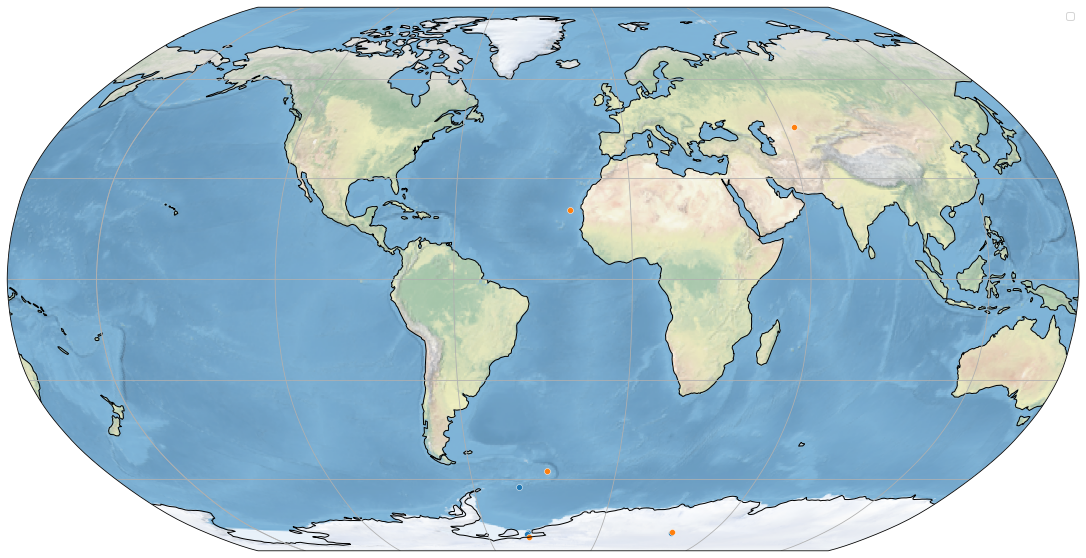

In [233]:
fig = plt.figure(figsize=(20,10))

proj = ccrs.Robinson(central_longitude=-30)#Robinson()

ax = plt.axes(projection=proj)    
ax.coastlines()
ax.stock_img()
ax.gridlines()

sns.scatterplot(x = df_vgps['slat_1'], y = df_vgps['slon_1'], transform = ccrs.PlateCarree())
sns.scatterplot(x = df_vgps['slat_2'], y = df_vgps['slon_2'], transform = ccrs.PlateCarree())

handles, labels = ax.get_legend_handles_labels()
ax.legend(reversed(handles), reversed(labels))
plt.show()

### invert vgp for those negative inclinations

In [234]:
def backward(X):
    
    if len(X) == 2:               
        X[0] = -X[0]
        X[1] = X[1] + np.pi if X[1] < np.pi else  X[1] - (np.pi)       
        #print(np.array(X)*180/np.pi)
        return X    
    if len(X) == 3:
            if X[2]<0:
                X[0] = -X[0]
                X[1] = -X[1]
                X[2] = -X[2]
                return X
    
    return X

In [235]:
df_vgps['VGP_lat'] = df_vgps.apply(lambda row: backward([np.radians(row.VGP_lat),np.radians(row.VGP_lon)])[0]*180/np.pi if row.inc < 0 else row.VGP_lat, axis=1)
df_vgps['VGP_lon'] = df_vgps.apply(lambda row: backward([np.radians(row.VGP_lat),np.radians(row.VGP_lon)])[1]*180/np.pi if row.inc < 0 else row.VGP_lat, axis=1)

,VGP_lat,VGP_lon
0,86.6,167.7
1,78.6,240.8
2,82.3,301.7
3,75.5,253.0
4,65.3,201.2
5,82.9,18.0
6,NaN,NaN
7,NaN,NaN
8,NaN,NaN
9,NaN,NaN


In [237]:
df_vgps['slat_1'] = df_vgps.apply(lambda row: get_site_coordinates(row.dec, row.inc, row.VGP_lat, row.VGP_lon)[0][0] if (row.Calculate_site == True) else row.slat, axis =1) # where 9999 is a function to be built
df_vgps['slon_1'] = df_vgps.apply(lambda row: get_site_coordinates(row.dec, row.inc, row.VGP_lat, row.VGP_lon)[0][1] if (row.Calculate_site == True) else row.slon, axis =1) # where 9999 is a function to be built
df_vgps['slat_2'] = df_vgps.apply(lambda row: get_site_coordinates(row.dec, row.inc, row.VGP_lat, row.VGP_lon)[1][0] if (row.Calculate_site == True) else row.slat, axis =1) # where 9999 is a function to be built
df_vgps['slon_2'] = df_vgps.apply(lambda row: get_site_coordinates(row.dec, row.inc, row.VGP_lat, row.VGP_lon)[1][1] if (row.Calculate_site == True) else row.slon, axis =1) # where 9999 is a function to be built

df_vgps['slat_1'] = df_vgps.apply(lambda row: cartesian2spherical(spherical2cartesian([np.radians(row.slat_1),np.radians(row.slon_1)]))[0]*180/np.pi, axis =1)
df_vgps['slon_1'] = df_vgps.apply(lambda row: cartesian2spherical(spherical2cartesian([np.radians(row.slat_1),np.radians(row.slon_1)]))[1]*180/np.pi, axis =1)
df_vgps['slat_2'] = df_vgps.apply(lambda row: cartesian2spherical(spherical2cartesian([np.radians(row.slat_2),np.radians(row.slon_2)]))[0]*180/np.pi, axis =1)
df_vgps['slon_2'] = df_vgps.apply(lambda row: cartesian2spherical(spherical2cartesian([np.radians(row.slat_2),np.radians(row.slon_2)]))[1]*180/np.pi, axis =1)

In [238]:
df_vgps[['name','slat_1','slon_1','slat_2','slon_2']]

,name,slat_1,slon_1,slat_2,slon_2
0,1,35.570498,153.177848,38.276190,-159.977848
1,2,20.638749,-159.410513,38.146550,101.010513
2,3,23.810781,-37.369751,38.205653,100.769751
3,6,38.233041,103.271030,64.011110,-132.271030
4,7,28.315652,122.428105,38.551065,99.971895
5,8,37.962007,98.649588,40.280676,117.350412
6,1,-90.000000,NaN,90.000000,NaN
7,2,-90.000000,NaN,90.000000,NaN
8,3,-90.000000,NaN,90.000000,NaN
9,4,-90.000000,NaN,90.000000,NaN


# visualizing the outcome

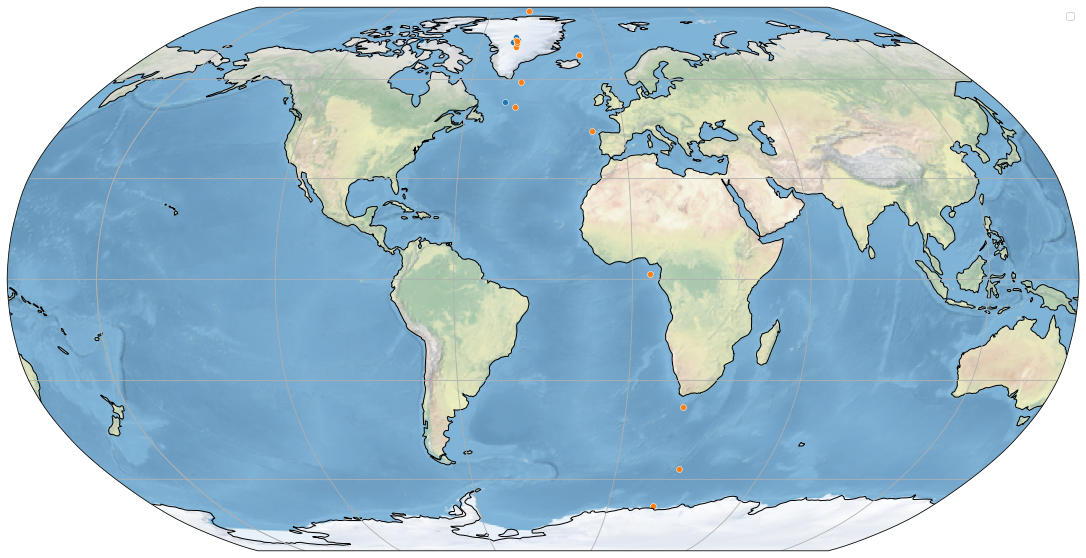

In [42]:
fig = plt.figure(figsize=(20,10))

proj = ccrs.Robinson(central_longitude=-30)#Robinson()

ax = plt.axes(projection=proj)    
ax.coastlines()
ax.stock_img()
ax.gridlines()

sns.scatterplot(x = df_vgps['slat_1'], y = df_vgps['slon_1'], transform = ccrs.PlateCarree())
sns.scatterplot(x = df_vgps['slat_2'], y = df_vgps['slon_2'], transform = ccrs.PlateCarree())

handles, labels = ax.get_legend_handles_labels()
ax.legend(reversed(handles), reversed(labels))
plt.show()